In [2]:
# adapted from https://www.tensorflow.org/tutorials/generative/autoencoder

import tensorflow as tf
from tensorflow.keras import losses, datasets, Model
from load_oxford_flowers102 import load_oxford_flowers102
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten, Concatenate

# Load Oxford Flowers dataset
train_data, validation_data, test_data, class_names = load_oxford_flowers102(imsize=96, fine=True)

x_train = train_data["images"]
x_test = test_data["images"]
x_valid = validation_data["images"]

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_valid = x_valid.astype('float32') / 255.

2024-04-12 16:07:26.944823: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-12 16:07:27.668812: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 16:07:28.779525: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jet/miniconda3/envs/tf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqd

# Define U-Net like model

In [3]:
# adapted from https://medium.com/geekculture/u-net-implementation-from-scratch-using-tensorflow-b4342266e406

def encode_block(inputs, n_filters):
    conv = Conv2D(n_filters, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    conv = Conv2D(n_filters, kernel_size=(3,3), activation='relu', padding='same')(conv)
    out = MaxPooling2D(strides=(2,2))(conv)
    skip = conv
    return out, skip

def decode_block(inputs, skip, n_filters):
    upconv = Conv2DTranspose(n_filters, kernel_size=(3,3), strides=(2,2), padding='same')(inputs)
    concat = Concatenate()([upconv, skip])
    conv = Conv2D(n_filters, kernel_size=(3,3), activation='relu', padding='same')(concat)
    out = Conv2D(n_filters, kernel_size=(3,3), activation='relu', padding='same')(conv)
    return out

def bottleneck(inputs, n_filters):
    conv = Conv2D(n_filters, kernel_size=(3,3), activation='relu', padding='same')(inputs)
    conv = Conv2D(n_filters, kernel_size=(3,3), activation='relu', padding='same')(conv)
    return conv

def create_unet(input_shape, n_filters=32):
    inputs = Input(input_shape)

    encode1, skip1 = encode_block(inputs, n_filters=32)
    encode2, skip2 = encode_block(encode1, n_filters=64)
    encode3, skip3 = encode_block(encode2, n_filters=128)
    # encode4, skip4 = encode_block(encode3, n_filters=256)

    latent_dim = bottleneck(encode3, n_filters=512)

    # decode1 = decode_block(latent_dim, skip4, n_filters=256)
    decode2 = decode_block(latent_dim, skip3, n_filters=128)
    decode3 = decode_block(decode2, skip2, n_filters=64)
    decode4 = decode_block(decode3, skip1, n_filters=32)

    out = Conv2D(3, kernel_size=(1,1), padding='same')(decode4)

    model = tf.keras.Model(inputs=inputs, outputs=out)
    return model        

unet = create_unet(x_train[0].shape, n_filters=32)
unet.summary()

2024-04-12 16:07:32.538184: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 16:07:32.827609: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 16:07:32.827953: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 96, 96, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 96, 96,    │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 96, 96,    │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 48, 48,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 48, 48,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 48, 48,    │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 24, 24,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 24, 24,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 24, 24,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 12, 12,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 12, 12,    │    590,336 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 12, 12,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 24, 24,    │    589,952 │ conv2d_7[0][0]    │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 24, 24,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 256)              │            │ conv2d_5[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 24, 24,    │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 24, 24,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 48, 48,    │     73,792 │ conv2d_9[0][0]  

 Total params: 4,500,515 (17.17 MB)

 Trainable params: 4,500,515 (17.17 MB)

 Non-trainable params: 0 (0.00 B)

# Train as Autoencoder

In [4]:
# unet.compile(optimizer=tf.keras.optimizers.Adam(), 
#              loss=tf.keras.losses.MeanSquaredError())
# unet.fit(x_train, x_train,
#          epochs=10,
#          shuffle=True,
#          validation_data=(x_test, x_test))

I0000 00:00:1712894853.364226   12790 service.cc:145] XLA service 0x7dde18016810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712894853.364258   12790 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-04-12 16:07:33.405872: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-12 16:07:33.552754: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


I0000 00:00:1712894854.841457   12790 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


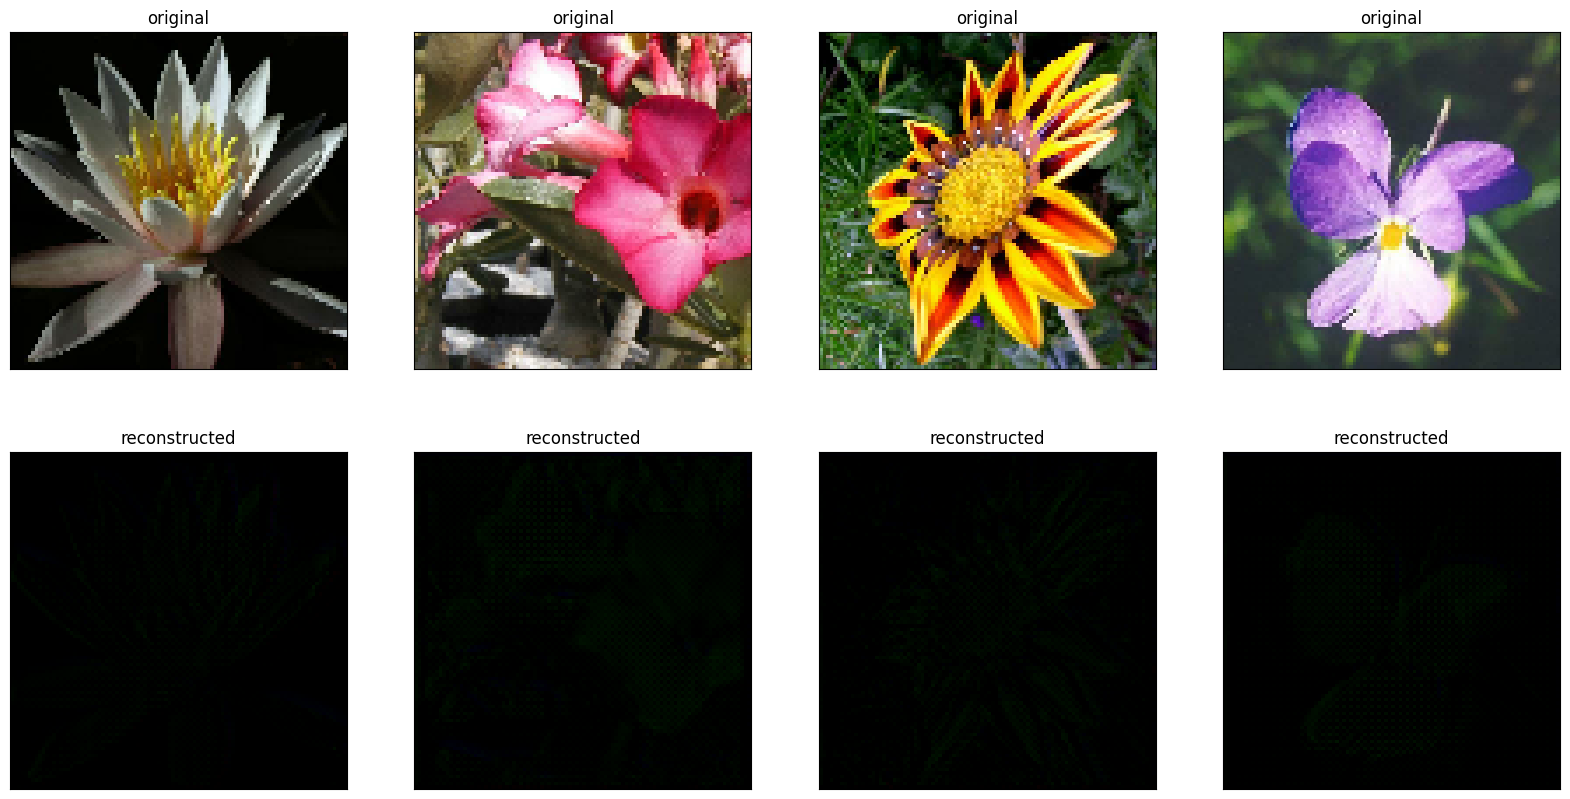

In [5]:
original_imgs = x_test[:10]
reconstructed_imgs = unet.predict(x_test[:10])

n = 4
plt.figure(figsize=(20, 10))
for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.title("original")
    plt.imshow(tf.squeeze(original_imgs[i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(reconstructed_imgs[i]))
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

# Generate Noisy Dataset

In [6]:
def incremental_noise(images, noise_factor_increment=0.25, n_increments=10):
    noisy_images = []
    noisy_labels = []

    for image in images:
        for _ in range(n_increments):
            noisy_labels.append(image) # relatively clean image

            image = image + noise_factor_increment * tf.random.normal(shape=image.shape) 

            image = tf.clip_by_value(image, clip_value_min=0., clip_value_max=1.)

            noisy_images.append(image) # noisier image

    noisy_images = np.array(noisy_images)
    noisy_labels = np.array(noisy_labels)
    return noisy_images, noisy_labels

def other_noise(images, noise_factor_increment=0.1, n_increments=10):
    noisy_images = []
    noisy_labels = []

    for image in images:
        for i in range(1, n_increments+1):

            noisy_image = image + noise_factor_increment * i * tf.random.normal(shape=image.shape) 
            image_label = image + noise_factor_increment * (i-1) * tf.random.normal(shape=image.shape)

            noisy_image = tf.clip_by_value(noisy_image, clip_value_min=0., clip_value_max=1.)
            image_label = tf.clip_by_value(image_label, clip_value_min=0., clip_value_max=1.)

            noisy_labels.append(image_label) # relatively clean image
            noisy_images.append(noisy_image) # noisier image

    noisy_images = np.array(noisy_images)
    noisy_labels = np.array(noisy_labels)
    return noisy_images, noisy_labels

In [7]:
x_train_noisy, y_train_noisy = incremental_noise(x_train)
# x_test_noisy, y_test_noisy = incremental_noise(x_test)
# x_valid_noisy, y_valid_noisy = incremental_noise(x_valid)

In [8]:
x_valid_noisy, y_valid_noisy = incremental_noise(x_valid)



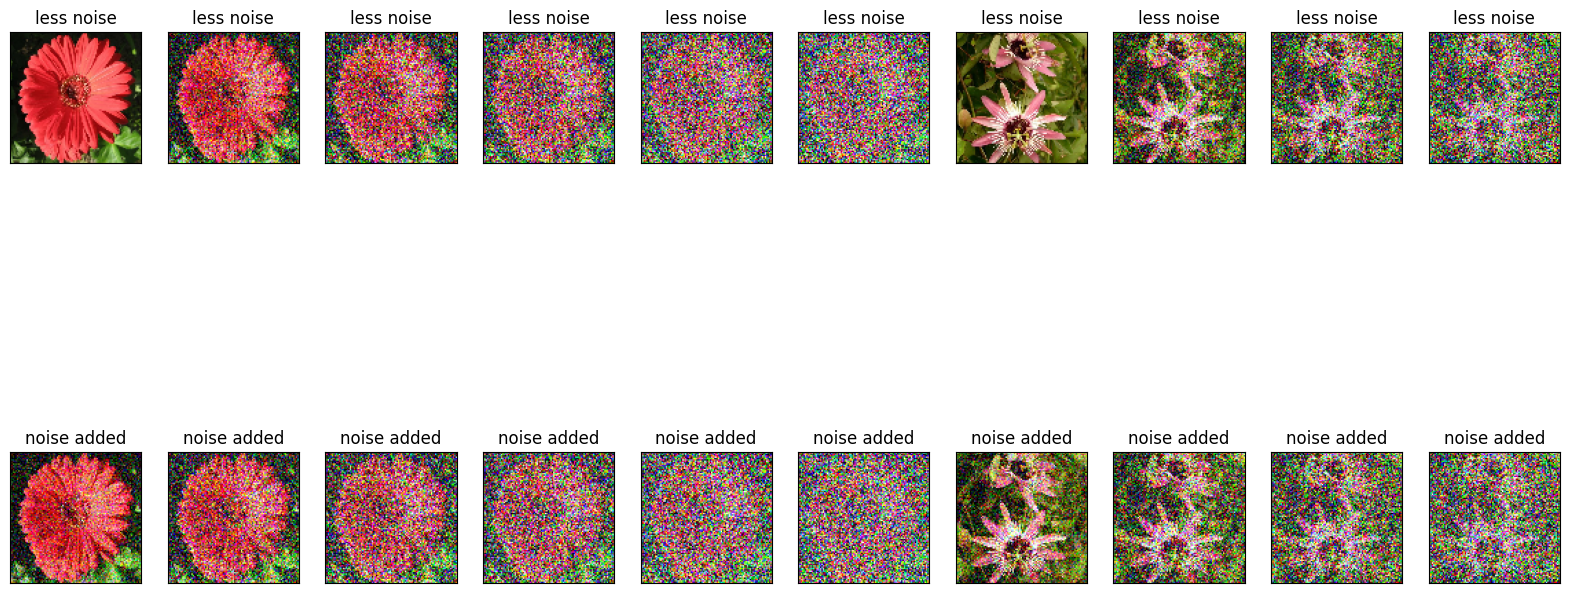

In [9]:
n = 10
plt.figure(figsize=(20, 10))
for i in range(n):

    # display less noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("less noise")
    plt.imshow(tf.squeeze(y_train_noisy[i*2]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display more noise
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("noise added")
    plt.imshow(tf.squeeze(x_train_noisy[i*2]))
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

# Train as Generative Model

In [9]:
unet = create_unet(x_train[0].shape, n_filters=32)
unet.compile(optimizer=tf.keras.optimizers.Adam(), 
             loss=tf.keras.losses.MeanSquaredError())
unet.fit(x_train_noisy, y_train_noisy,
            epochs=10,
            shuffle=True,
            validation_data=(x_valid_noisy, y_valid_noisy))

: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/s

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


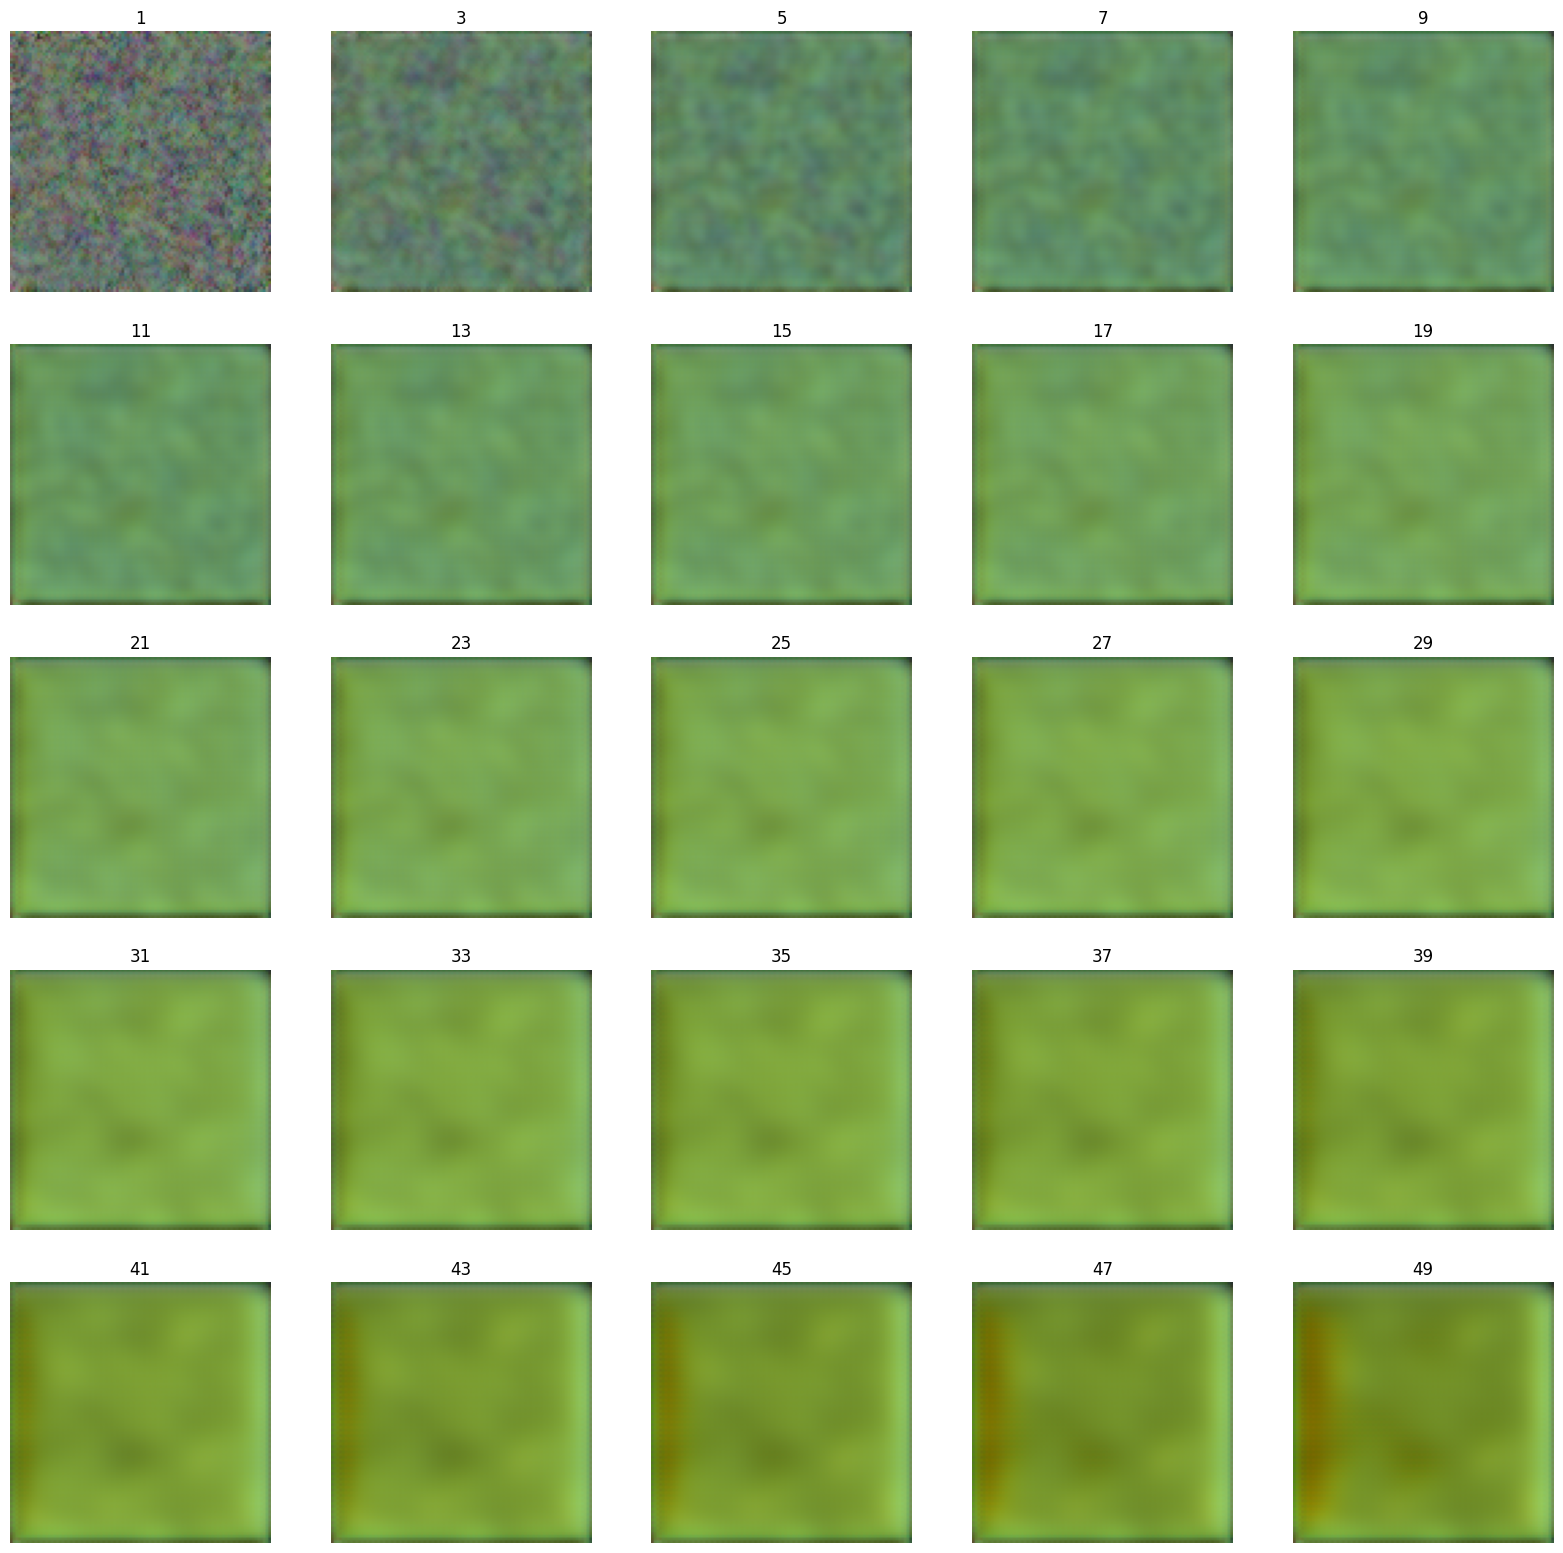

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf

n_images = 1
n_iterations = 50
base_images = tf.ones((n_images, 96, 96, 3)) * 0
noise_images = base_images + tf.random.uniform((n_images, 96, 96, 3))
# noise_images = base_images + [gen_pink_noise((96,96,3)) for _ in range(n_images)]

noise_images = tf.clip_by_value(noise_images, clip_value_min=0.0, clip_value_max=0.6)
generated_flowers = unet.predict(noise_images)

n_cols = 5
n_rows = (n_iterations + 1) // n_cols + ((n_iterations + 1) % n_cols != 0)

plt.figure(figsize=(20, 4 * n_rows))
for i in range(n_iterations):
    generated_flowers = unet.predict(generated_flowers)

    plt.subplot(n_rows, n_cols, i // 2 + 1)
    plt.title(f'{i}')
    plt.imshow(tf.squeeze(generated_flowers[0]))
    plt.axis('off')
plt.show()
